<a href="https://colab.research.google.com/github/DanielBR0612/unsupervised-network-ids/blob/main/Unsupervised_Network_Anomaly_Detection_CSE_CIC_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar o dataset

In [1]:
import os

meu_usuario = "danielbragaa"
minha_chave = "KGAT_7f527e1e30ae41a871547d40663449d7"

# Cria o diretorio
!mkdir -p ~/.kaggle

with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(f'{{"username":"{meu_usuario}","key":"{minha_chave}"}}')

# 3. Muda a permissão do arquivo (exigência de segurança do Kaggle)
!chmod 600 ~/.kaggle/kaggle.json

# 4. Instala a biblioteca do Kaggle
!pip install -q kaggle

print("Configuração concluída")

# Baixar o dataset específico
print("Iniciando download...")
!kaggle datasets download -d solarmainframe/ids-intrusion-csv

# Descompactar o arquivo zip
print("Descompactando arquivos...")
!unzip -q ids-intrusion-csv.zip


# Ao carregar o dataset, foi baixado vários arquivos que correspondem a vários tipos de ataque, listei aqui para vc poder selecionar qual quer analisar

arquivos_disponiveis = {
    # ATAQUES DE FORÇA BRUTA & ACESSO
    '02-14-2018.csv': 'FTP-BruteForce, SSH-Bruteforce',

    # ATAQUES DE NEGAÇÃO DE SERVIÇO (DoS)
    '02-15-2018.csv': 'DoS-GoldenEye, DoS-Slowloris',
    '02-16-2018.csv': 'DoS-SlowHTTPTest, DoS-Hulk',

    # ATAQUES DISTRIBUÍDOS (DDoS)
    '02-20-2018.csv': 'DDoS-LOIC-HTTP, DDoS-LOIC-UDP',
    '02-21-2018.csv': 'DDoS-LOIC-UDP, DDoS-HOIC',
    # ATAQUES WEB (SQL INJECTION / XSS)
    '02-22-2018.csv': 'Web Brute Force, XSS, SQL Inj',
    '02-23-2018.csv': 'Web Attack - SQL Injection',

    # OUTROS
    '02-28-2018.csv': 'Infiltration', # evitar esse por enquanto, dificil de analisar
    '03-01-2018.csv': 'Botnet',
    '03-02-2018.csv': 'Botnet'
}


Configuração concluída
Iniciando download...
Dataset URL: https://www.kaggle.com/datasets/solarmainframe/ids-intrusion-csv
License(s): Attribution 4.0 International (CC BY 4.0)
100% 1.59G/1.60G [00:21<00:00, 249MB/s]
100% 1.60G/1.60G [00:21<00:00, 80.4MB/s]
Descompactando arquivos...


# Juntar vários arquivos em apenas um

In [2]:
import pandas as pd
import numpy as np
import gc

arquivos_para_analise = [
    '02-14-2018.csv',
    '02-16-2018.csv'
]

FRACAO_AMOSTRA = 0.10

lista_dfs = []

print(f"Iniciando carga de {len(arquivos_para_analise)} arquivos...")

for arquivo in arquivos_para_analise:
    print(f"--> Lendo {arquivo}...")

    df_temp = pd.read_csv(arquivo, low_memory=False)

    df_sample = df_temp.sample(frac=FRACAO_AMOSTRA, random_state=42)

    lista_dfs.append(df_sample)

    del df_temp
    gc.collect()

print("Combinando os datasets...")
df_final = pd.concat(lista_dfs, axis=0)

df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

print("="*50)
print(f"DATASET FINAL CRIADO!")
print(f"Dimensões Totais: {df_final.shape}")
print("="*50)

Iniciando carga de 2 arquivos...
--> Lendo 02-14-2018.csv...
--> Lendo 02-16-2018.csv...
Combinando os datasets...
DATASET FINAL CRIADO!
Dimensões Totais: (209716, 80)


# Limpeza dos dados

In [3]:
colunas_para_remover = [
    'Label',
    'Timestamp',
    'Flow ID',
    'Src IP', 'Dst IP',
    'Src Port'
]

X = df_final.drop(columns=colunas_para_remover, errors='ignore')

print(f"Dados para o Modelo (X): {X.shape}")

Dados para o Modelo (X): (209716, 78)


In [4]:
import numpy as np

print(f"Tamanho antes: {X.shape}")

X = X.apply(pd.to_numeric, errors='coerce')

X.replace([np.inf, -np.inf], np.nan, inplace=True)

indices_validos = X.dropna().index
X = X.loc[indices_validos]

print(f"Tamanho depois: {X.shape}")



Tamanho antes: (209716, 78)
Tamanho depois: (209328, 78)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Rodando UMAP na amostra


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


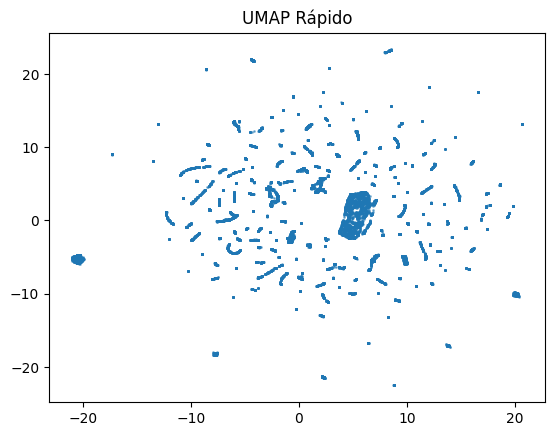

In [44]:
import umap
import matplotlib.pyplot as plt

# reduzi o tamanho pra ver se roda
indices = np.random.choice(X_scaled.shape[0], 20000, replace=False)
X_sample = X_scaled[indices]

print("Rodando UMAP na amostra")

# to rodando sem random_state pq n tava dando n, 30 min e nada
umap_instancia = umap.UMAP(n_neighbors=30, min_dist=0.01, n_components=2, random_state=42)
umap_2d = umap_instancia.fit_transform(X_sample)

plt.scatter(umap_2d[:, 0], umap_2d[:, 1], s=1, alpha=0.5)
plt.title("UMAP Rápido")
plt.show()

## Aplicar o DBSCAN aos resultados do UMAP

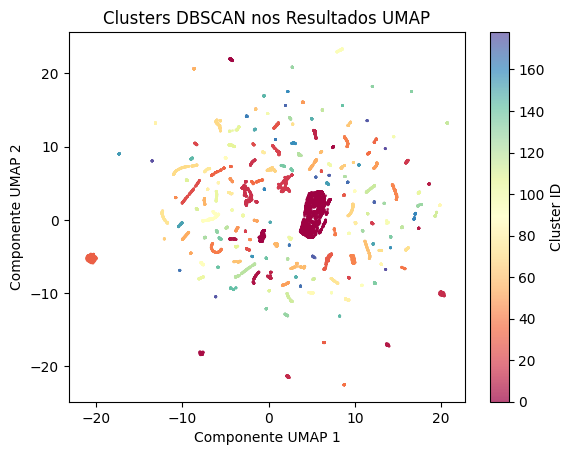

In [45]:
from sklearn.cluster import DBSCAN

dbscan_instancia = DBSCAN(eps=0.5, min_samples=4)
clusters = dbscan_instancia.fit_predict(umap_2d)

plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=clusters, cmap='Spectral', s=1, alpha=0.7)
plt.colorbar(label='Cluster ID')
plt.title('Clusters DBSCAN nos Resultados UMAP')
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.show()

### Achar eps ideal

In [46]:
from sklearn.neighbors import NearestNeighbors

k = 4
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_sample)

distances, indices = neigh.kneighbors(X_sample)
distances_to_kth_neighbor = distances[:, k-1]

print(f"Distancias até o {k} vizinho mais próximo. Shape: {distances_to_kth_neighbor.shape}")

Distancias até o 4 vizinho mais próximo. Shape: (20000,)


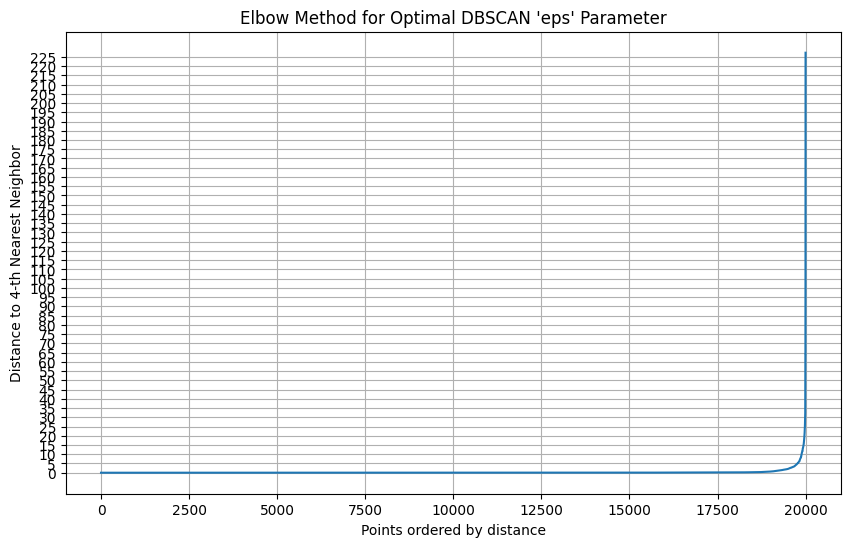

In [67]:
# Ordenar as distâncias
sorted_distances = np.sort(distances_to_kth_neighbor, axis=None)

# Plotar as distâncias ordenadas
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title("Elbow Method for Optimal DBSCAN 'eps' Parameter")
plt.xlabel("Points ordered by distance")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.yticks(np.arange(0, max(distances_to_kth_neighbor), 5))
plt.grid(True)
plt.show()

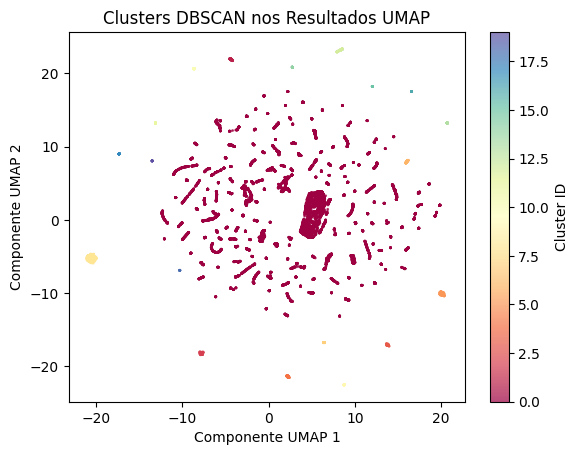

In [68]:
dbscan_instancia = DBSCAN(eps=2.5, min_samples=4)
clusters = dbscan_instancia.fit_predict(umap_2d)

plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=clusters, cmap='Spectral', s=1, alpha=0.7)
plt.colorbar(label='Cluster ID')
plt.title('Clusters DBSCAN nos Resultados UMAP')
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.show()

## Aplicar o KMeans aos resultados do UMAP

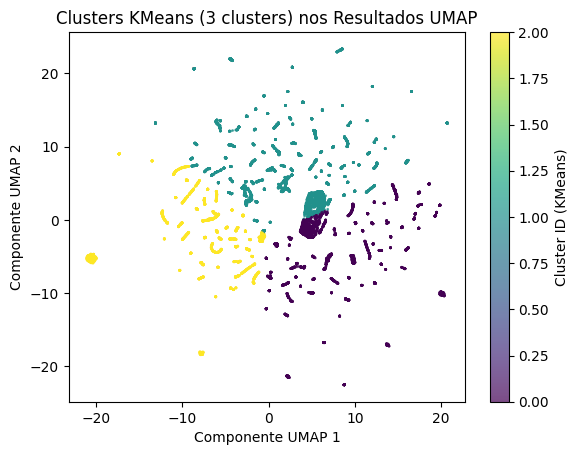

In [69]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Número de clusters
n_clusters = 3

kmeans_instancia = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
clusters_kmeans = kmeans_instancia.fit_predict(umap_2d)

# Visualizar os clusters KMeans nos resultados do UMAP
plt.scatter(umap_2d[:, 0], umap_2d[:, 1], c=clusters_kmeans, cmap='viridis', s=1, alpha=0.7)
plt.colorbar(label='Cluster ID (KMeans)')
plt.title(f'Clusters KMeans ({n_clusters} clusters) nos Resultados UMAP')
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.show()

### Achar n_clusters ideal

In [70]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(umap_2d)
    wcss.append(kmeans.inertia_)

print("WCSS de 1 a 10 clusters:")
print(wcss)

WCSS de 1 a 10 clusters:
[3398917.5, 2231527.0, 1487810.625, 1187762.0, 918240.4375, 717747.4375, 640685.9375, 488747.15625, 431918.25, 393728.6875]


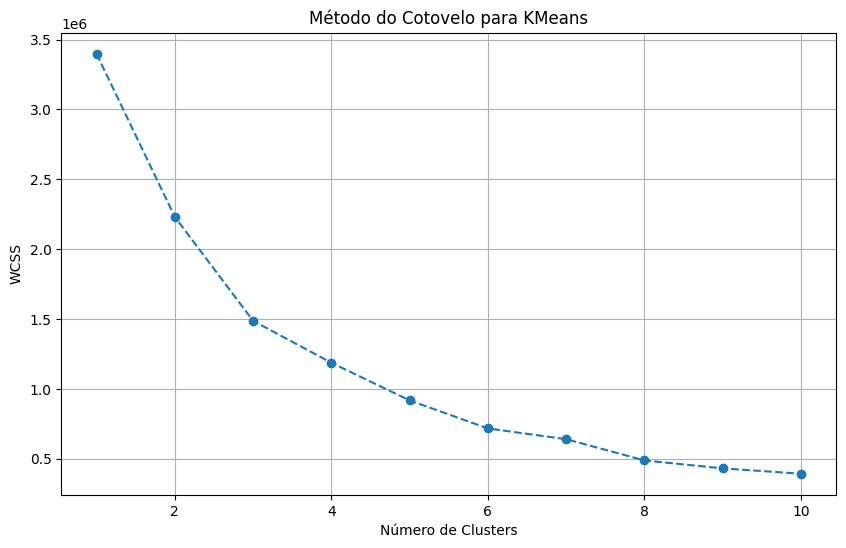

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Método do Cotovelo para KMeans')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()
# n_clusters = 3 pareceu ter sido o ideal